# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

## Calibrating and synthetic simulation of single-site Rainfall with the NSRPM.

In this script we calibrate the NSRPM (Neyman Scott Rectangular Pulse Model) using two rainfall series with different rainfall regimes: one with daily data located in the north of Spain, on a temperate climate (Cfb), and other with hourly data located in New Mexico (USA) on a semi-arid climate (BSh-BSk). The calibration parameters are used to simulate several decades of synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other applications.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

<font color='red'>Please, be advised that some of the processes may take up to 5 minutes in a modern computer.</font>

### Load packages

In [15]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from NEOPRENE.NSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.NSRP.Calibration import Calibration
from NEOPRENE.NSRP.Statistics import Statistics
from NEOPRENE.NSRP.Simulation import Simulation
from NEOPRENE.NSRP.utils import compare_statistics, exceedence_probability, disaggregate_rainfall, figure_disaggregation
from NEOPRENE.NSRP.Analysis import Analysis

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Example 1. Calibration and validation of daily data

### Loading daily rainfall data for daily data point

In [4]:
Serie_PD = pd.read_csv('auxiliary-materials/Point_Daily.csv', sep=";", decimal=".", index_col=0, parse_dates=True)
Serie_PD[Serie_PD.values<0] = np.nan
Input_Serie = pd.DataFrame(index=Serie_PD.index)
Input_Serie['Rain'] = Serie_PD.values

### Plotting daily data and seasonality

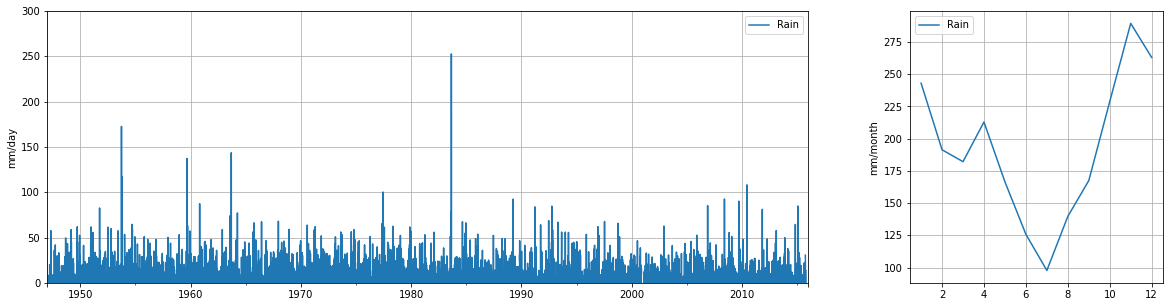

In [5]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Serie.index.year[0])
t2=str(Input_Serie.index.year[-1])
Input_Serie.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Serie.groupby(lambda x: x.month)
Month_sum = grouped_m.sum()*24/(len(Input_Serie>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month');

### Calibration

The calibration input file ([Input_Cal_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_PD.yml)) contains the hyperparameters to calibrate the model. This hyperparameters are loaded by the ```Calibration``` class within the ```NEOPRENE.NSRP.HiperParams``` module. In this notebook, the module is loaded as ```Calhps```.

Input rainfall statistics can be directly calculated by the software from a time series or can be introduced from a file with the statistics (both options are shown in the present notebook).

A description of the hyperparamters available in the calibration file ([Input_Cal_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_PD.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

In [6]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_PD.yml')

The original time series statistics are computed first, as the model calibrates against those statistics. Once the statistics have been computed, the library does not need the complete time series anymore.

In [7]:
# Input statistics calculated from a Rainfall serie
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Serie)

# Input statistics from file 
#statistics_model_2 = Statistics(hiper_params_cal, file = 'auxiliary-materials/statististics_PD.csv')

The hyperparameters are passed to the Calibration class which return a calibrator object. This object can be used as a function, that receives the statistics that need to be reproduced by the model. The object can also save the calibrated parameters to disk for later use.

In [8]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, verbose=False)
#CAL2             = CAL(statistics_model_2, verbose=False)

os.makedirs('./POINT_DAILY/CAL1/',exist_ok=True)

CAL1.save_files('./POINT_DAILY/CAL1/')
#CAL2.save_files('./CAL2/')



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)




In [9]:
CAL1.Fitted_parameters

,1,2,3,4,5,6,7,8,9,10,11,12
landa,0.152787,0.104198,0.101312,0.148505,0.166258,0.162813,0.092584,0.027611,0.135768,0.109866,0.135423,0.149700
ipsilon,12.032033,25.691890,18.719391,8.940917,5.903372,2.952001,7.075441,17.583986,2.856317,9.081771,13.639559,11.823122
eta,36.031407,62.419896,52.886949,29.814064,29.794314,18.549886,33.611387,17.556636,11.257861,21.884965,31.235986,32.377381
xi,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000,0.012000
betha,0.480000,0.480000,0.880531,0.490220,0.652030,0.909346,1.622887,1.126399,0.919937,0.480000,0.480000,0.480000


### Simulation

The input simulation file ([Input_Sim_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_PD.yml)) contains the hypermarametes for rainfall simulation.

A description of the hyperparamters available in the simulation file ([Input_Sim_PD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_PD.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

The first thing we do is to load the hyperparameters

In [10]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_PD.yml')

And those hyperparameters are then used to configure the Simulation class, which return a Simulation object that is used in a very similar way to the Calibration object.

In [11]:
SIM              = Simulation(hiper_params_sim) 

# Input parameters from the model
SIM1             = SIM(params_cal = CAL1)

# Input parameters from a dataframe

os.makedirs('./POINT_DAILY/SIM1/',exist_ok=True)
SIM1.save_files('./POINT_DAILY/SIM1/')

#SIM2             = SIM(params_cal = './CAL2/Calibrated_parameters.csv')
#SIM2.save_files('./SIM1/')



################################################################################
Synthetic simulation


Total cumulative rainfall - Analytical estimation =        97031.50
Total cumulative rainfall -             Simulated =        96655.13


## Analysis of results
In this section, an analysis of the results is made. 

In [12]:
Analysis_results = Analysis(CAL1,SIM1)

### Verification

The curve of exceedence probabilities is shown to evaluate the quality of the fit of the simulations and the observations

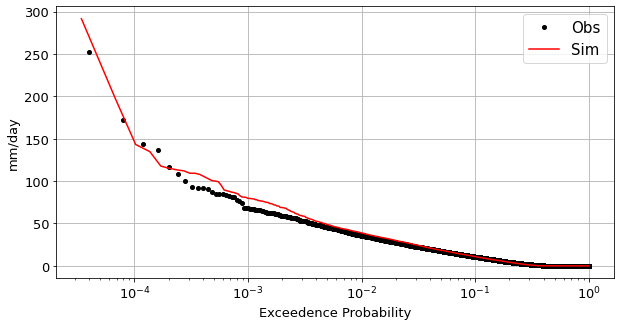

In [13]:
# Comparing exceedence Probability betwen Observed and Simulated series
Analysis_results.exceedence_probability_fig(Input_Serie, SIM1.Daily_Simulation)

### Validation

Another set of verification plots is generated where the value of different observed statistics (dashed line) is compared against the fitted statistics (blue squares), that is, the best values of the statistic that the optimal parameters were able to reproduce, and against the simulated statistics (red triangles), the values of the statistics that were obtained when simulating synthetic time series with the calibrated parameters.

The model correctly reproduces those parameters for which it is calibrated. Those parameters that do not participate in the calibration procedure may exhibit a more erratic behavior, thus the differences between the calibrated and simulated values of the statistics.

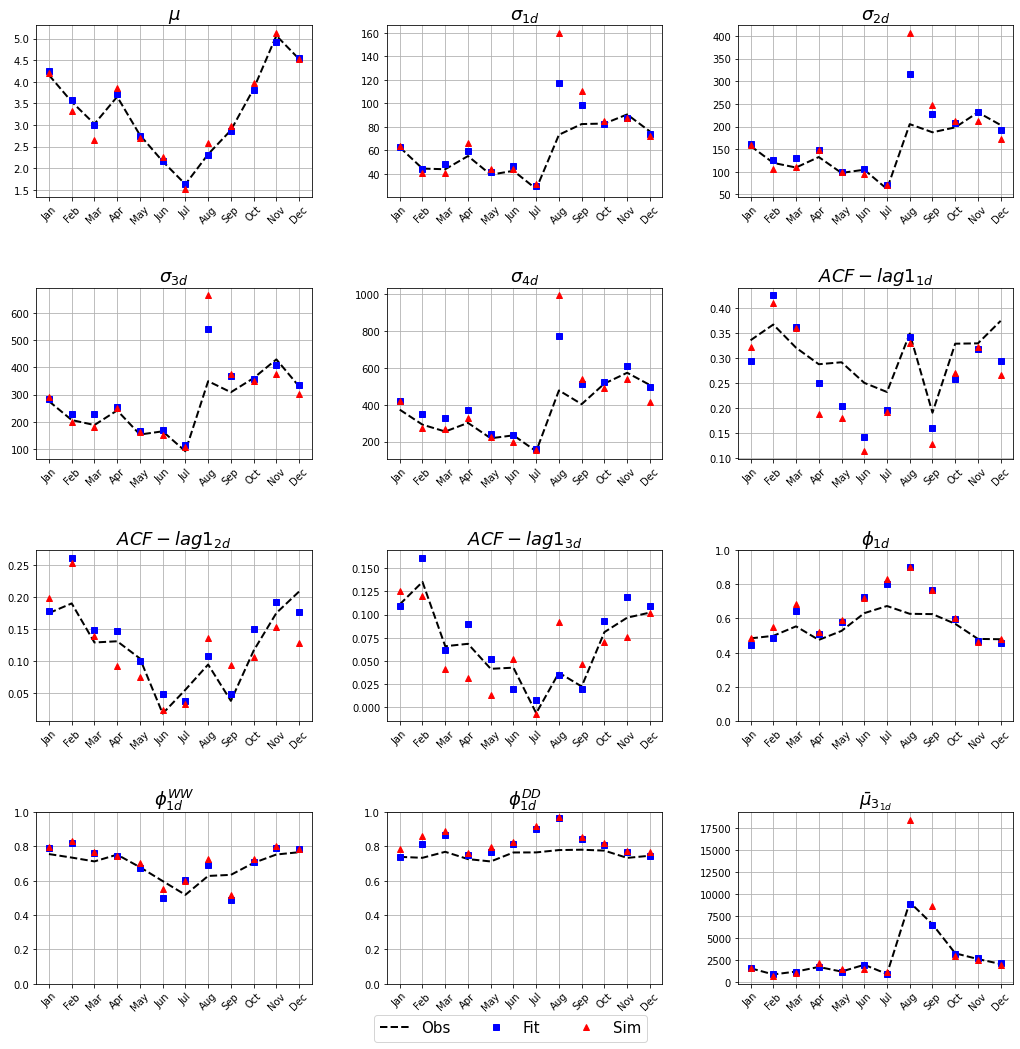

In [21]:
# Comparing the values of the statistcs (observed, fitted and simulated).
Analysis_results.compare_statistics_fig()

# Example 2. Disaggregation of daily data to hourly data

Disaggregation process might take some minutes to dissagregate several decades of data. Here we select only 5 year as an example

In [22]:
# Period selected from the input (onserved) serie
year1 = 2000; year2 = 2005
x_series = Input_Serie[(Input_Serie.index.year >= year1) & (Input_Serie.index.year < year2)]

In [23]:
# Defining hourly synthetic serie
y_series = SIM1.Hourly_Simulation.copy()

In [24]:
# Daily-to-hourly disaggregation
hourly_disaggregation = disaggregate_rainfall(x_series, y_series)

In [25]:
# Resampling hourly disaggregated serie to daily one
daily_disaggregation = hourly_disaggregation.resample('D').agg(pd.Series.sum, min_count=1)
# Calculating statistics from the disaggregated daily resample serie and for the period selected from the Input serie
statistics_model_3 = Statistics(hiper_params_cal, time_series = x_series)
statistics_disaggregated = Statistics(hiper_params_cal, time_series = daily_disaggregation)

In [26]:
# Comparing daily observed statiscis with dialy dissagregated ones

statistics_model_3.statististics_dataframe.compare(statistics_disaggregated.statististics_dataframe)

1                       2                       3  \
                    self       other        self       other        self   
mean            3.507258    2.802771    2.702817    2.699720    2.089677   
var_1          41.278254   34.205682   26.169006   25.966448   24.566345   
var_2         114.271697   93.802679   69.624087   69.048469   64.404748   
var_3         191.495883  173.218659  114.143424  113.020779   86.517336   
var_4         244.190762  229.779882  149.908573  148.958754  153.306287   
autocorr_1_1    0.404013    0.436803    0.431723    0.431559    0.262477   
autocorr_2_1    0.138685    0.186045    0.203420    0.203769    0.113781   
autocorr_3_1    0.058755    0.108677    0.059803    0.060344   -0.012867   
fih_1           0.516129    0.616883    0.521127    0.528169         NaN   
fiWW_1          0.750000    0.694915    0.632353    0.597015    0.629032   
fiDD_1          0.765625    0.810526    0.662162    0.640000    0.752688   
M3_1          632.177191  539.520027  331.922783  325.019639  417.915617   

                                   4                       5              ...  \
                   other        self       other        self       other  ...   
mean            2.087233    2.910000    2.901803    2.270323    2.264282  ...   
var_1          24.649995   31.787167   31.523254   25.825700   25.605103  ...   
var_2          64.355664   78.969857   78.350414   76.422623   75.328216  ...   
var_3          86.785533  108.986697  108.001803  129.231451  127.399816  ...   
var_4         153.218046  186.852243  184.629315  149.577874  147.399819  ...   
autocorr_1_1    0.258543    0.291502    0.289488    0.440110    0.433688  ...   
autocorr_2_1    0.114697   -0.006437   -0.009578    0.231821    0.230534  ...   
autocorr_3_1   -0.013747   -0.062024   -0.061740   -0.025212   -0.024018  ...   
fih_1                NaN    0.433333    0.460000         NaN         NaN  ...   
fiWW_1          0.612903    0.776471    0.703704    0.609375    0.593750  ...   
fiDD_1          0.741935    0.707692    0.652174    0.725275    0.714286  ...   
M3_1          422.509447  552.230324  542.220973  409.973966  404.678475  ...   

                       8                       9                      10  \
                    self       other        self       other        self   
mean            1.465161    1.461575    1.595333    1.592352    3.713548   
var_1          14.645625   14.640926   24.285778   24.330974   48.780268   
var_2          39.471373   39.534184   48.443716   47.989223  107.637725   
var_3          54.320972   54.313809   76.135189   75.469387  185.415352   
var_4          96.148759   95.913647   82.866222   81.922878  236.532834   
autocorr_1_1    0.249681    0.248749    0.012462    0.005681    0.209096   
autocorr_2_1    0.245928    0.242184   -0.024377   -0.024172    0.065464   
autocorr_3_1    0.181772    0.184344   -0.022858   -0.022211   -0.021027   
fih_1           0.638710    0.658065         NaN         NaN    0.496774   
fiWW_1          0.696429    0.603774    0.551020    0.510204    0.705128   
fiDD_1          0.828283    0.794118    0.782178    0.762376    0.701299   
M3_1          242.032888  243.240689  648.894994  650.283723  841.705477   

                                   11                        12               
                   other         self        other         self        other  
mean            3.697660     4.966187     4.604695     5.054032     4.022592  
var_1          48.211975    64.706555    61.870659   101.595064    85.286586  
var_2         106.148480   147.754517   144.158751   302.384470   245.657226  
var_3         182.591187   195.728830   196.132646   516.092908   418.646036  
var_4         233.758097   319.808040   318.599900   872.480826   522.153508  
autocorr_1_1    0.211663     0.136999     0.154628     0.583768     0.590585  
autocorr_2_1    0.062108    -0.086107    -0.066289     0.424919     0.437411  
autocorr_3_1   -0.020840    -0.055104    -0.045

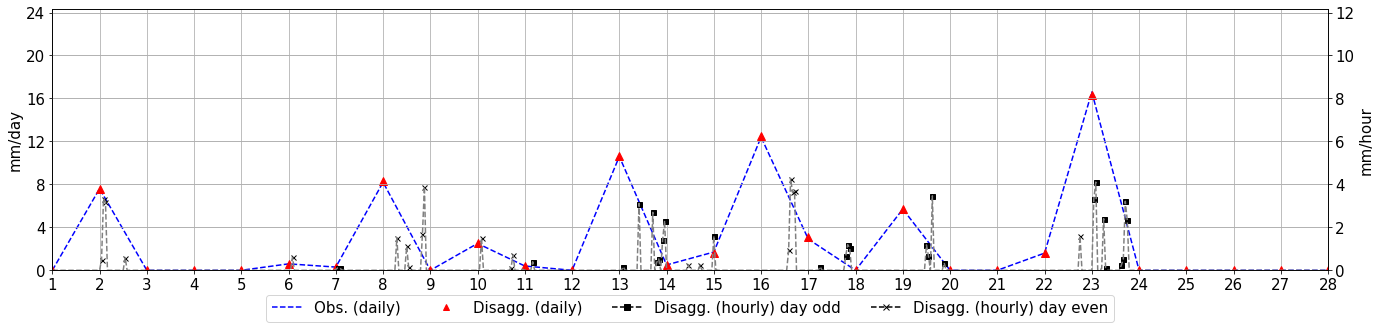

In [27]:
Analysis_results.figure_disaggregation_fig(hourly_disaggregation,daily_disaggregation,x_series,year1,year1)

### Save Figures
To save the figures in png format we execute the following line

In [28]:
Analysis_results.save_figures('./POINT_DAILY/Figures/')

# Example 3. Calibration and Simulation of hourly data

### Loading hourly rainfall data for hourly data point

In [29]:
Serie_PH=pd.read_csv('auxiliary-materials/Point_Hourly.csv', sep=",", decimal=".", index_col=0, parse_dates = True)
Serie_PH[Serie_PH.values<0]=np.nan
Input_Serie=pd.DataFrame(index=Serie_PH.index)
Input_Serie['Rain']=Serie_PH.values

### Plotting hourly data and seasonality

Text(0, 0.5, 'mm/month')

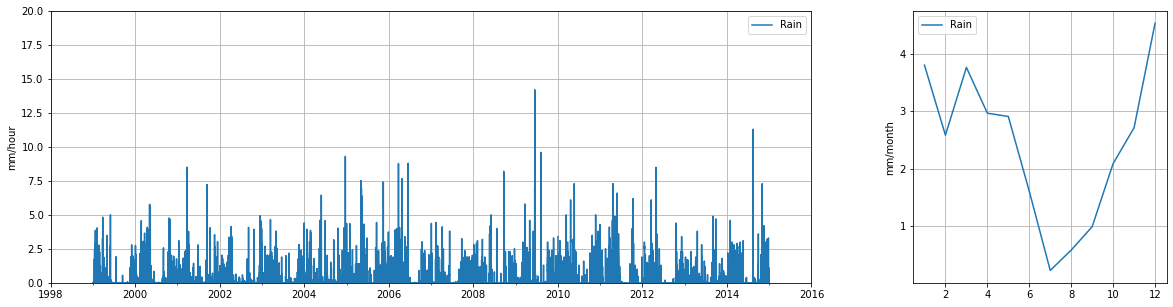

In [30]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Serie.index.year[0]); t2=str(Input_Serie.index.year[-1])
Input_Serie.plot(xlim=(t1, t2),  ylim=(0, 20), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/hour')

grouped_m = Input_Serie.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Serie>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

### Calibration

In [31]:
hiper_params_cal = Calhps('./Input_Cal_PH.yml')
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Serie)

In [32]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, verbose=False)

os.makedirs('./POINT_HOURLY/CAL1/', exist_ok=True)

CAL1.save_files('./POINT_HOURLY/CAL1/')



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)




### Simulation

In [33]:
hiper_params_sim = Simhps('./Input_Sim_PH.yml')

SIM              = Simulation(hiper_params_sim) 
SIM1             = SIM(params_cal = CAL1)
#SIM2             = SIM(params_cal = './CAL2/Calibrated_parameters.csv')



################################################################################
Synthetic simulation


Total cumulative rainfall - Analytical estimation - Storm 1 =          872.26
Total cumulative rainfall - Analytical estimation - Storm 2 =         1175.10
Total cumulative rainfall - Analytical estimation =         2047.36
Total cumulative rainfall -             Simulated =         1810.92


In [34]:
os.makedirs('./POINT_HOURLY/SIM1/',exist_ok=True)
SIM1.save_files('./POINT_HOURLY/SIM1/')

## Analysis of results
In this section, an analysis of the results is made. 

In [35]:
Analysis_results = Analysis(CAL1,SIM1)

### Validation

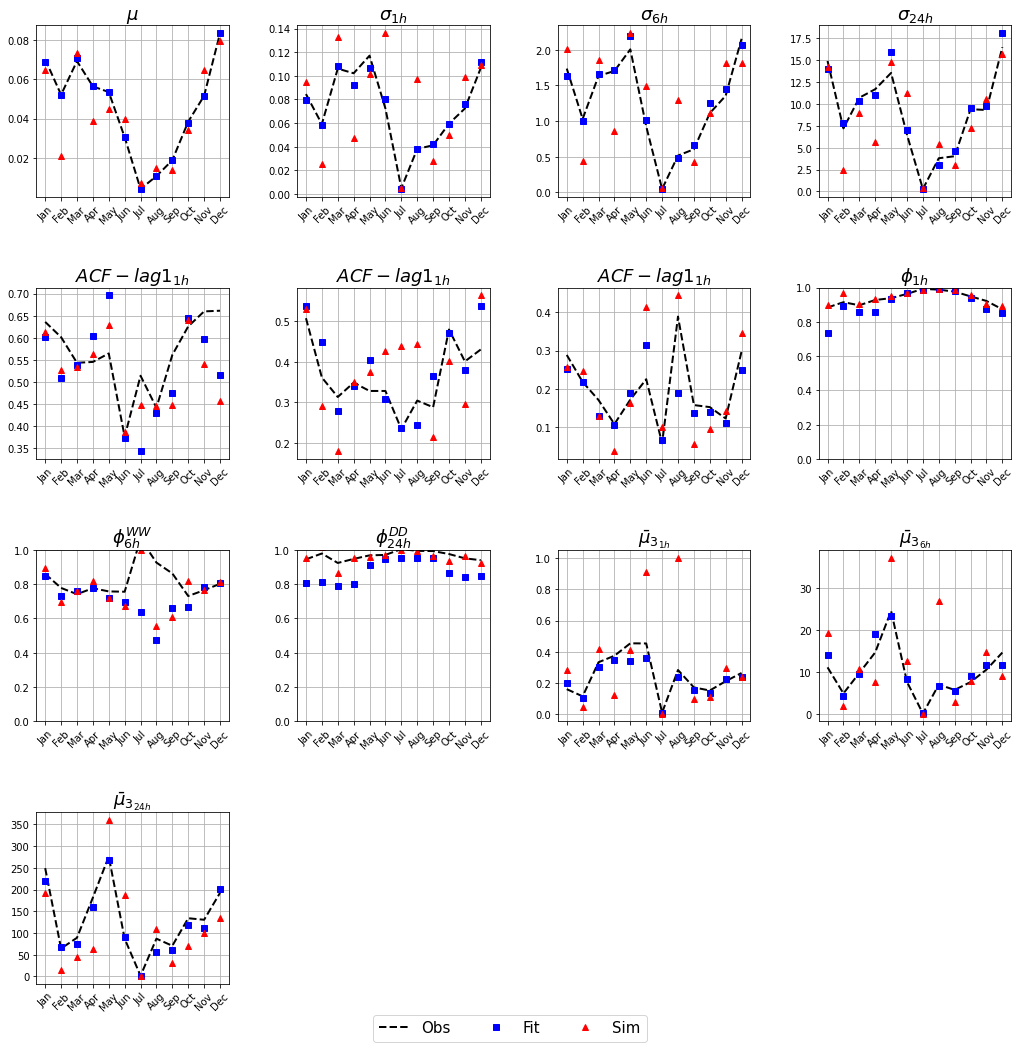

In [36]:
# Comparing the values of the statistcs (observed, fitted and simulated).
Analysis_results.compare_statistics_fig()

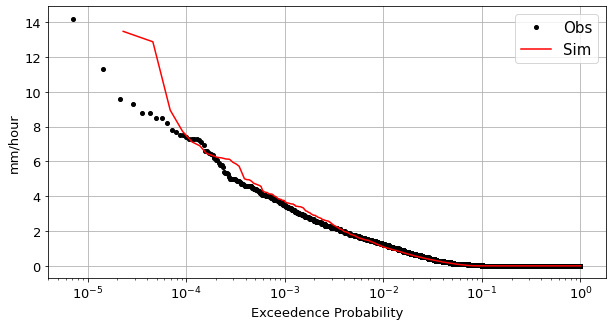

In [37]:
# Comparing exceedence Probability betwen Observed and Simulated series
Analysis_results.exceedence_probability_fig(Input_Serie, SIM1.Hourly_Simulation)

### Save Figures
To save the figures in png format we execute the following line

In [38]:
Analysis_results.save_figures('./POINT_HOURLY/Figures/')

# Session info

In [39]:
!conda list

# packages in environment at C:\Users\navass\Anaconda3\envs\NEOPRENE:
#
# Name                    Version                   Build  Channel
anyio                     3.4.0            py39hcbf5309_0    conda-forge
argon2-cffi               20.1.0           py39h2bbff1b_1  
async_generator           1.10               pyhd3eb1b0_0  
attrs                     21.2.0             pyhd3eb1b0_0  
babel                     2.9.1              pyh44b312d_0    conda-forge
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    4.0.0              pyhd3eb1b0_0  
brotlipy                  0.7.0           py39hb82d6ee_1003    conda-forge
ca-certificates           2021.10.8            h5b45459_0    conda-forge
certifi                   2021.10.8        py39hcbf5309_1    conda-forge
cffi                      1.15.0           py39h2bbff1b_0  
charset-normalizer        2.0.8              pyhd8ed1ab_0    conda-forge
c